In [27]:
import hashlib
import os
import pandas as pd
import textwrap
import tqdm
from datetime import datetime
from glob import glob
from ipywidgets import interact
from trainscrape import get_city_mapping
from IPython.display import display, Markdown
import matplotlib.pyplot as plt

cities = get_city_mapping()

def display_md(text):
    return display(Markdown(textwrap.dedent(text)))

In [28]:
def load_file(filename):
    file = (
        pd
        .read_csv(filename)
        .assign(filename=filename)
    )
    if 'Unnamed: 0' in file.columns:
        file = file.drop(columns='Unnamed: 0')
    return file

filenames = glob('out/**/*.csv', recursive=True)
files = map(load_file, filenames)
files = tqdm.tqdm_notebook(files, total=len(filenames))
raw_df = (
    pd
    .concat(files, sort=True)
    .reset_index(drop=True)
)

In [29]:
key_cols = [
    'departure_station',
    'arrival_station',
    'departure_time',
    'arrival_time',
    'duration_minutes',
    'date',
]
index_cols = key_cols + [
    'scrape_time',
]
cols = index_cols + [
    #'departure_city',
    #'arrival_city',
    'key',
    'cost',
    #'available',
]


def get_key(values):
    values = [str(x) for x in values]
    text = '\n'.join(values)
    hash_ = hashlib.sha384(text.encode()).hexdigest()
    return hash_[:20]

df = (
    raw_df
    #.reset_index()
    .assign(
        key=(
            raw_df
            [key_cols]
            .apply(get_key, axis=1)
        ),
        scrape_time=(
            pd
            .to_datetime(raw_df['scrape_time'])
            .apply(lambda x: x.replace(microsecond=0))
        )
    )
    [cols]
    #.set_index(index_cols)
)

In [32]:
stations = sorted(df['arrival_station'].unique())

@interact(
    departure_station=stations,
    arrival_station=stations,
)
def f(departure_station='Amsterdam Sloterdijk', arrival_station='Berlin Alexanderplatz', show_keys=False):
    idx1 = df['departure_station'] == departure_station
    idx2 = df['arrival_station'] == arrival_station
    out = (
        df
        [idx1 & idx2]
        .sort_values(index_cols)
        .fillna('')
        .iloc[15:]
        .drop(columns=['departure_station', 'arrival_station'])
        .set_index([x for x in index_cols if x not in ['departure_station', 'arrival_station']])
    )
    if not show_keys:
        out = out.drop(columns=['key'])
    return out

interactive(children=(Dropdown(description='departure_station', index=1, options=('Amsterdam Bijlmer', 'Amster…

## Price history viewer

interactive(children=(Text(value='bc1adb30b9c86dc86488', description='key'), Output()), _dom_classes=('widget-…

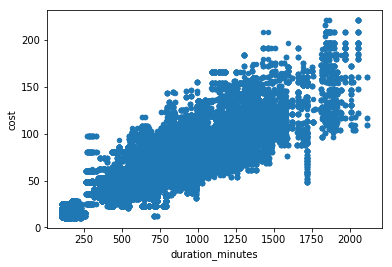

In [33]:
display(Markdown('## Price history viewer'))

df2 = df.reset_index()
now = datetime.now()
    
@interact()
def f(key='bc1adb30b9c86dc86488'):
    matches = df2[df2['key'] == key]
    if len(matches) != 0:
        info = matches.iloc[0]
        title = '{} -> {}\n{} - {}   {}'.format(
            info['departure_station'],
            info['arrival_station'],
            info['departure_time'],
            info['arrival_time'],
            info['date']
        )
        costs = (
            matches
            .set_index('scrape_time')
            ['cost']
            .rename('cost')
        )
        ylim = (costs.min() - 5, costs.max() + 5)
        costs.plot(
            style='o-',
            ylim=ylim,
            title=title,
        )
        
df.plot.scatter(x='duration_minutes', y='cost')
pass

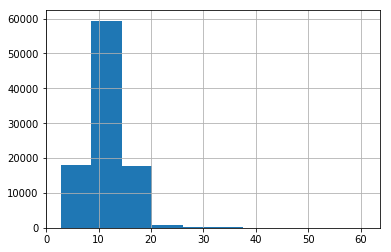

In [13]:
(df['duration_minutes'].astype(float) / df['cost'].astype(float)).hist()

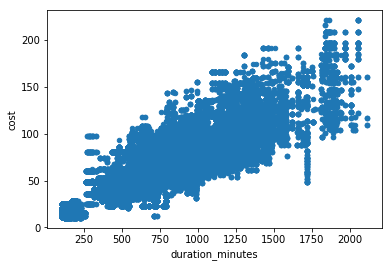